In [39]:
import pandas as pd
drug_data = pd.read_csv('full_drug_new.csv')
data = pd.read_csv('data/runs/n_results.csv', index_col='run')

In [38]:
data['model'].unique()

array(['DecisionTreeRegressor', 'SVR', 'ElasticNet',
       'KNeighborsRegressor', 'RandomForestRegressor', nan], dtype=object)

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats

In [569]:
data = pd.read_csv('data/runs/n_results.csv', index_col='run')
drug_data = pd.read_csv('full_drug.csv')
#drug_data = pd.read_csv('data/runs/drug_data.csv')

# Data cleaning

In [40]:
data = data[data['status']=='completed']
data = data[data['r_2_mean'].notnull()]

data['time'] = pd.to_timedelta(data['time'])
data['started'] = pd.to_datetime(data['started'])
data['seconds'] = data['time'].apply(lambda x:x.seconds)

data['datasets'] = data['gdsc']+data['ctrp']+data['ccle']
data = data[data['datasets']>0]

# The only valid daata
ndata = data[data['started'] > pd.to_datetime('2020-04-15 18:00:00')]

# Joint drug data
drug_data_j = drug_data.join(ndata, rsuffix='_drug', on='run')
drug_data_j = drug_data_j[drug_data_j['started'].notnull()]
ndrug_data = drug_data_j[drug_data_j['started'] > pd.to_datetime('2020-04-15 18:00:00')]
full_data = drug_data.join(data, on='run', rsuffix='_drug')

In [571]:
ndata.describe()

,time,ajive,cutoff,drugs,n,test,threshold,step,r_2_mean,r_2_std,seconds
count,3901,1813.000000,3901.0,3901.000000,3901.000000,0.0,3901.00,3901.0,3901.000000,3900.000000,3901.000000
mean,0 days 00:58:26.734427,2.020408,4.0,19.995129,0.097727,NaN,0.01,0.0,0.060908,0.229286,3418.141759
std,0 days 01:45:41.426394,0.805693,0.0,0.304204,0.056837,NaN,0.00,0.0,0.291535,1.016499,5583.322548
min,0 days 00:00:33,1.000000,4.0,1.000000,0.000853,NaN,0.01,0.0,-10.539266,0.000876,33.000000
25%,0 days 00:09:18,1.000000,4.0,20.000000,0.047648,NaN,0.01,0.0,-0.020325,0.094116,558.000000
50%,0 days 00:30:23,2.000000,4.0,20.000000,0.097354,NaN,0.01,0.0,0.085522,0.128460,1823.000000
75%,0 days 01:06:33,3.000000,4.0,20.000000,0.145949,NaN,0.01,0.0,0.176236,0.197914,3993.000000
max,1 days 04:49:17,3.000000,4.0,20.000000,0.199802,NaN,0.01,0.0,0.414408,42.588642,82747.000000


# Per model

In [555]:
nmodels = ndata.groupby('model').median()
nmodels['Number of runs'] = [data[(data['model']==i) & (data['started'] > pd.to_datetime('2020-04-15 18:00:00'))].shape[0] for i in nmodels.index]
nmodels

,ajive,cutoff,drugs,n,test,threshold,step,r_2_mean,r_2_std,seconds,Number of runs
model,,,,,,,,,,,
DecisionTreeRegressor,2.0,4.0,20.0,0.097869,NaN,0.01,0.0,-0.078007,0.186813,1035.0,915
ElasticNet,2.0,4.0,20.0,0.095198,NaN,0.01,0.0,0.108096,0.100632,1772.0,1181
KNeighborsRegressor,2.0,4.0,20.0,0.089228,NaN,0.01,0.0,0.107251,0.118816,6525.5,452
RandomForestRegressor,2.0,4.0,20.0,0.089267,NaN,0.01,0.0,0.113352,0.116625,2869.0,763
SVR,2.0,4.0,20.0,0.113707,NaN,0.01,0.0,-0.028523,0.223193,1169.0,590


# AJIVE analysis

In [17]:
multiple = ndata[ndata['datasets']>1]
multiple.describe()[['r_2_mean', 'r_2_std', 'seconds']]

,r_2_mean,r_2_std,seconds
count,2937.000000,2936.000000,2937.000000
mean,0.126314,0.138288,4156.985700
std,0.135858,0.110563,6086.119711
min,-0.487365,0.000876,58.000000
25%,-0.002568,0.085358,847.000000
50%,0.127495,0.119778,2648.000000
75%,0.237904,0.180124,4880.000000
max,0.432360,2.029289,78169.000000


In [18]:
ajive = ndata[ndata['ajive'].notnull()]
ajive.describe()[['r_2_mean', 'r_2_std', 'seconds']]

,r_2_mean,r_2_std,seconds
count,3159.000000,3158.000000,3159.000000
mean,0.032533,0.411498,3017.405825
std,2.438732,10.854820,5713.897727
min,-136.615707,0.008371,33.000000
25%,-0.008734,0.103961,508.000000
50%,0.099307,0.138130,1650.000000
75%,0.191812,0.208678,3511.000000
max,0.432360,609.875488,82747.000000


In [19]:
drug_data[drug_data['Drug']=='17-AAG'].shape[0]

3996

# Hard to predict drugs

In [82]:
drugs = drug_data.groupby('Drug').agg({'r2_score': ['mean', 'std']})
drugs['runs'] = [drug_data[drug_data['Drug']==i].shape[0] for i in drugs.index]
one = drugs[drugs['runs']<50].sort_values(by=('r2_score', 'mean'), ascending=False)
multiple = drugs[drugs['runs']>50].sort_values(by=('r2_score', 'mean'), ascending=False)

In [43]:
ctrp = pd.read_csv('data/Processed/ctrp_poz_dr.csv')
gdsc = pd.read_csv('data/Processed/gdsc_poz_dr.csv')
ccle = pd.read_csv('data/Processed/ccle_poz_dr.csv')

In [85]:
scoring = {'Low':-1, 'Medium':0, 'High':1}
ctrp['IC'] = ctrp['IC50_quality'].replace(scoring)
gdsc['IC'] = gdsc['IC50_quality'].replace(scoring)
gdsc['IC'] = gdsc['IC50_quality'].replace(scoring)

In [86]:
dr = pd.concat([ctrp, gdsc, ccle])

/rwthfs/rz/cluster/home/kz035322/Thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [87]:
ctrp_low = ctrp[ctrp['IC50_quality']=='Low']['Drug_name'].unique()
gdsc_low = gdsc[gdsc['IC50_quality']=='Low']['Drug_name'].unique()
ccle_low = ccle[ccle['IC50_quality']=='Low']['Drug_name'].unique()

In [88]:
#low_ic = np.concatenate([ctrp_low, gdsc_low, ccle_low])

In [89]:
ic_dict = pd.concat([ctrp, gdsc, ccle]).groupby('Drug_name').mean()[['IC']]

/rwthfs/rz/cluster/home/kz035322/Thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [90]:
one['IC'] = [ic_dict.loc[i]['IC'] for i in one.index]
one['CCLs'] = [dr[dr['Drug_name']==i].shape[0] for i in one.index]

In [91]:
multiple['IC'] = [ic_dict.loc[i]['IC'] for i in multiple.index]
multiple['CCLs'] = [dr[dr['Drug_name']==i].shape[0] for i in multiple.index]

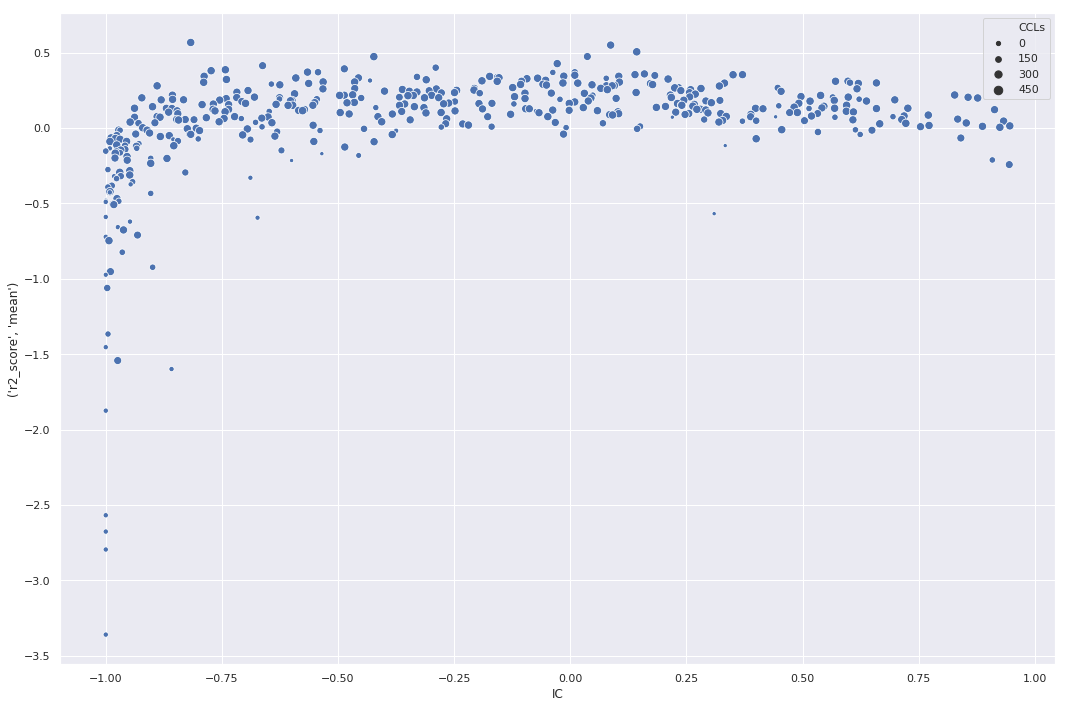

In [92]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x='IC', y=('r2_score', 'mean'), size='CCLs', data=one[one['r2_score']['mean']>-20], ax=ax)
plt.tight_layout()
#plt.savefig('IC quality vs r2.png')

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x='IC', y=('r2_score', 'mean'), size='CCLs', data=multiple[multiple['r2_score']['mean']>-20], ax=ax)
plt.tight_layout()

In [ ]:
drugs.sort_values(('r2_score', 'mean')).head()

In [ ]:
outliers = pd.DataFrame(columns=['ctrp', 'datasets', 'r2_score'])
for i in drugs[drugs['runs']<50].index:
    dr = drug_data_j[drug_data_j['Drug']==i]
    
    outliers.loc[i] = [dr['ctrp'].mean(), dr['datasets'].mean(), dr['r2_score'].mean()]

In [ ]:
outliers.describe()

In [ ]:
one.describe()

In [84]:
multiple.describe()

r2_score                     runs
             mean         std             
count  191.000000  191.000000   191.000000
mean     0.032323    0.541738   575.790576
std      0.652070    2.101970  1044.043631
min     -8.102517    0.089648    51.000000
25%      0.028997    0.282388   122.500000
50%      0.127681    0.313895   157.000000
75%      0.199764    0.358352   523.500000
max      0.417480   28.870028  4360.000000

In [ ]:
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(drugs[drugs['r2_score']['mean']>-2]['r2_score']['mean'], drugs[drugs['r2_score']['mean']>-2]['runs'])
ax.set_xlabel('r2')
ax.set_ylabel('number of runs')
ax.set_title('Average r2 per drug')
plt.savefig('Drug r2.png')

In [ ]:
low = drug_data_j[drug_data_j['Drug'].isin(one.index)]
high = drug_data_j[drug_data_j['Drug'].isin(multiple.index)]

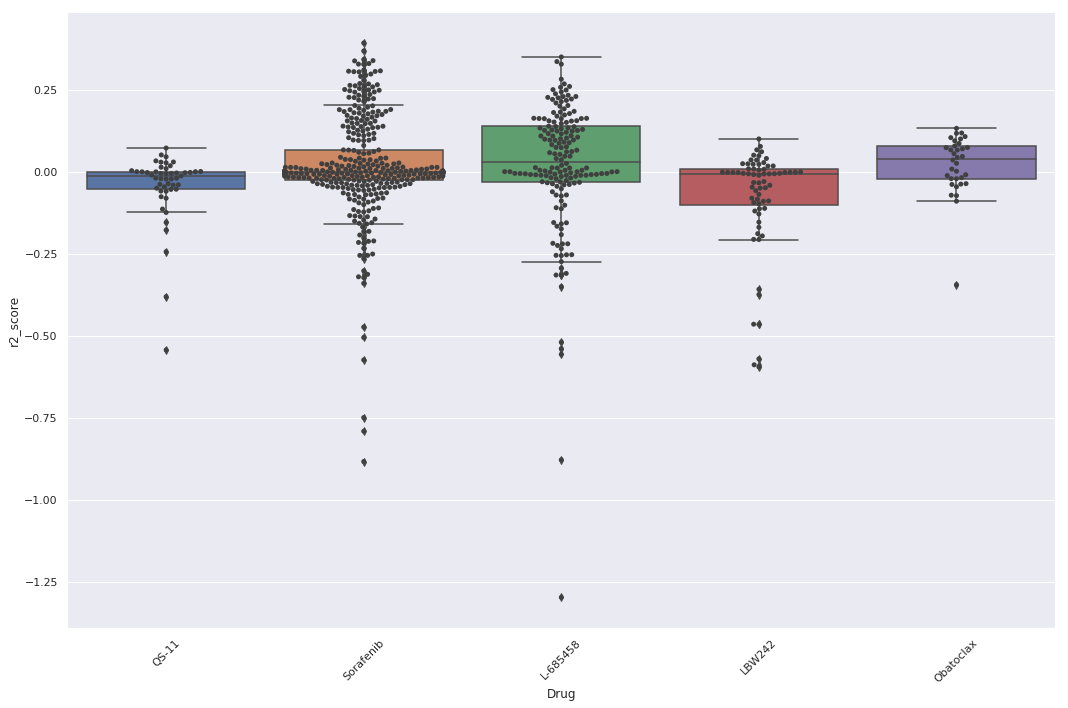

In [297]:
sns.set(font_scale=1)

g = sns.catplot(x= 'Drug', y='r2_score',data=high, kind='box', height=10, aspect=1.5)
sns.swarmplot(x= 'Drug', y='r2_score',data=high, color='.25')
g.set_xticklabels(rotation=45)
plt.tight_layout()
#plt.savefig('top drugs.png')

# IC/EC quality effect on r2

In [46]:
scoring = {'Low':-1, 'Medium':0, 'High':1}
ctrp['IC'] = ctrp['IC50_quality'].replace(scoring)
gdsc['IC'] = gdsc['IC50_quality'].replace(scoring)
gdsc['IC'] = gdsc['IC50_quality'].replace(scoring)

ctrp['EC'] = ctrp['EC50_quality'].replace(scoring)
gdsc['EC'] = gdsc['EC50_quality'].replace(scoring)
gdsc['EC'] = gdsc['EC50_quality'].replace(scoring)

In [131]:
c_dict = pd.concat([ctrp, gdsc, ccle], sort=True).groupby('Drug_name').mean()[['IC', 'EC', 'IC50_residual_standard_error', 'EC50_residual_standard_error']]

In [132]:
c_dict = pd.concat([ctrp, gdsc, ccle], sort=True).groupby('Drug_name').mean()[['IC', 'EC', 'IC50_residual_standard_error', 'EC50_residual_standard_error']]

In [134]:
#full = drug_data.join(data, on='run', rsuffix='_drug')
full['Quality'] = [c_dict.loc[full.loc[i]['Drug']]['IC'] if full.loc[i]['metric_drug']=='AUC_IC50' else c_dict.loc[full.loc[i]['Drug']]['EC'] for i in full.index]
#full['Error'] = [c_dict.loc[full.loc[i]['Drug']]['IC50_residual_standard_error'] if full.loc[i]['metric_drug']=='AUC_IC50' else c_dict.loc[full.loc[i]['Drug']]['EC50_residual_standard_error'] for i in full.index]

In [64]:
full['Quality'] = full['Quality'].fillna(-1)

In [139]:
#full.to_csv('data/runs/full.csv',index=False)

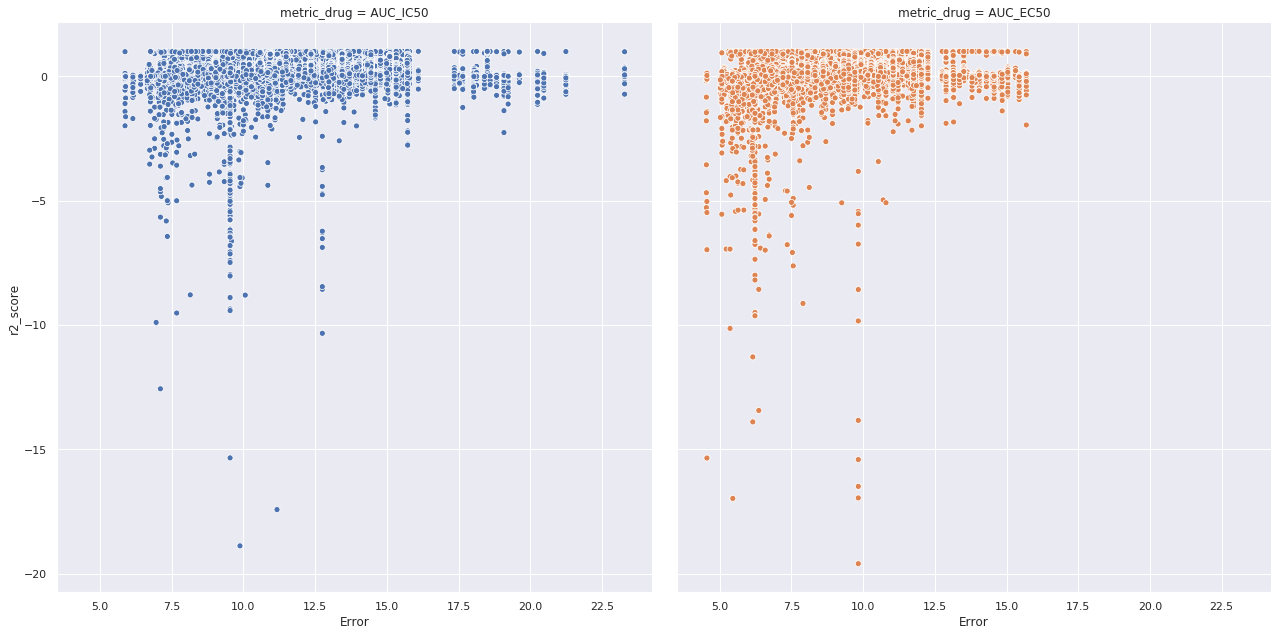

In [135]:
#sns.relplot(x='Error', y='r2_score', data=full[full['r2_score']>-20], kind='scatter', height=9, col='metric_drug', hue='metric_drug', legend=False)

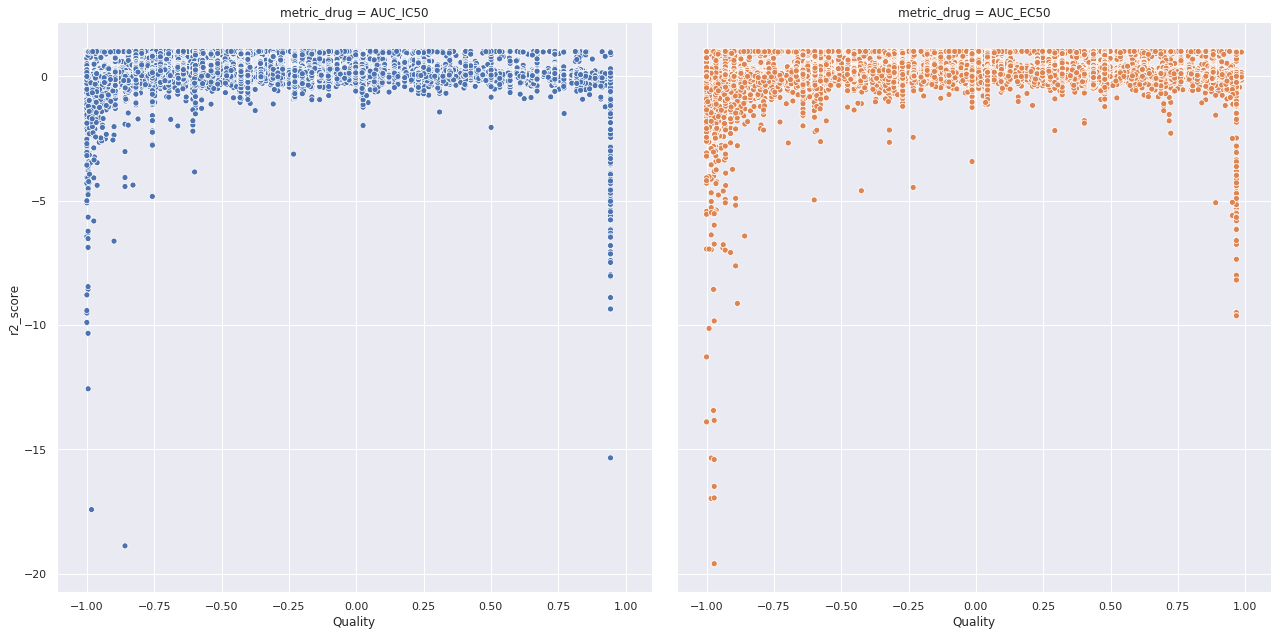

In [81]:
sns.relplot(x='Quality', y='r2_score', data=full[full['r2_score']>-20], kind='scatter', height=9, col='metric_drug', hue='metric_drug', legend=False)
plt.tight_layout()
#plt.savefig('IC quality vs r2.png')

In [95]:
drug_ic = full.groupby('Drug').mean()

In [97]:
drug_ic['CCLs'] = [dr[dr['Drug_name']==i].shape[0] for i in drug_ic.index]

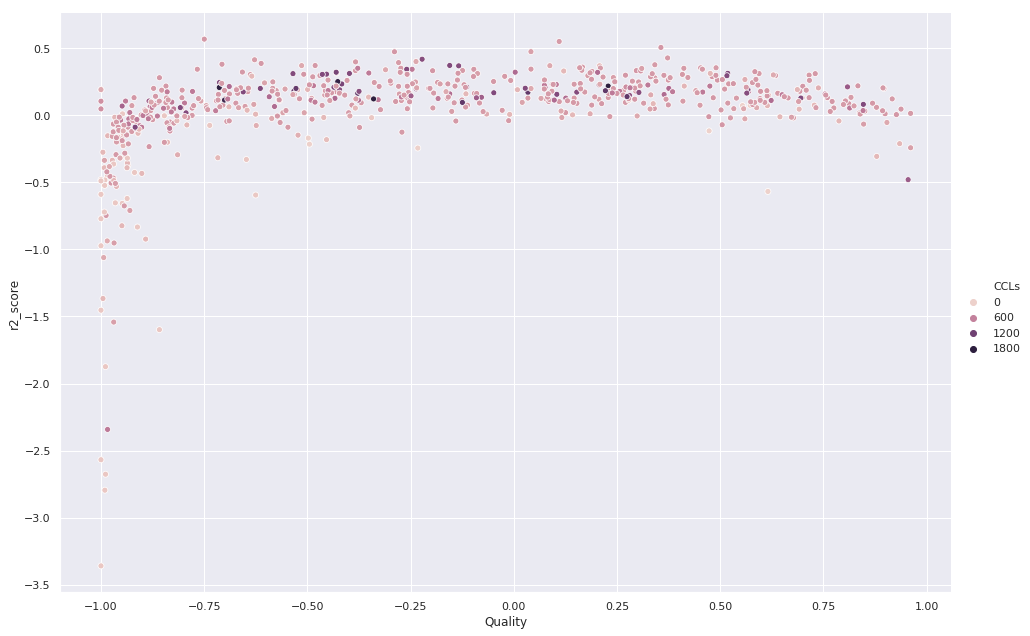

In [107]:
sns.relplot(x='Quality', y='r2_score', data=drug_ic[drug_ic['r2_score']>-4], hue='CCLs', kind='scatter', height=9, aspect=1.5)

#plt.savefig('IC quality vs r2.png')

# Best performing models on hardest drugs

In [ ]:
split = pd.concat([low, high], keys=['hard', 'easy']).reset_index().rename(columns={'level_0':'type'}).drop('level_1', axis=1)

In [ ]:
hard = low.groupby(['model', 'fs']).mean()[['r2_score', 'r_2_std']].reset_index()

In [ ]:
easy = high.groupby(['model', 'fs']).mean()[['r2_score', 'r_2_std']].reset_index()

In [ ]:
split = pd.concat([easy, hard], keys=['easy', 'hard']).reset_index().rename(columns={'level_0':'type'}).drop('level_1', axis=1)

In [ ]:
sns.set(font_scale=1)

g = sns.catplot(x='fs', y='r2_score', hue='type', data=split[split['r2_score']>-4], kind='boxen', height=10, aspect=1.5, legend=False)
#sns.swarmplot(x='fs', y='r2_score', hue='type',dodge=False, data=split[split['r2_score']>-4], ax=g.ax)
g.set_xticklabels(rotation=45)
g.fig.suptitle('Differences in feature selection performance between easy and hard drugs')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.legend(loc='lower left')
#plt.savefig('FS type of drug.png', bbox_inches='tight')


In [ ]:
g = sns.catplot(x='model', y='r2_score', hue='type', data=split[split['r2_score']>-25], kind='boxen', height=10, aspect=1.5, legend=False)
#sns.swarmplot(x='model', y='r2_score', hue='type',dodge=True, data=split[split['r2_score']>-4], ax=g.ax)
g.set_xticklabels(rotation=45)
g.fig.suptitle('Differences in model performance between easy and hard drugs')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.legend(loc = 'lower left')
#plt.savefig('Model type of drug.png')

# AJIVE rank vs r2

In [28]:
data = drug_data.join(ndata, on='run', rsuffix='drug')

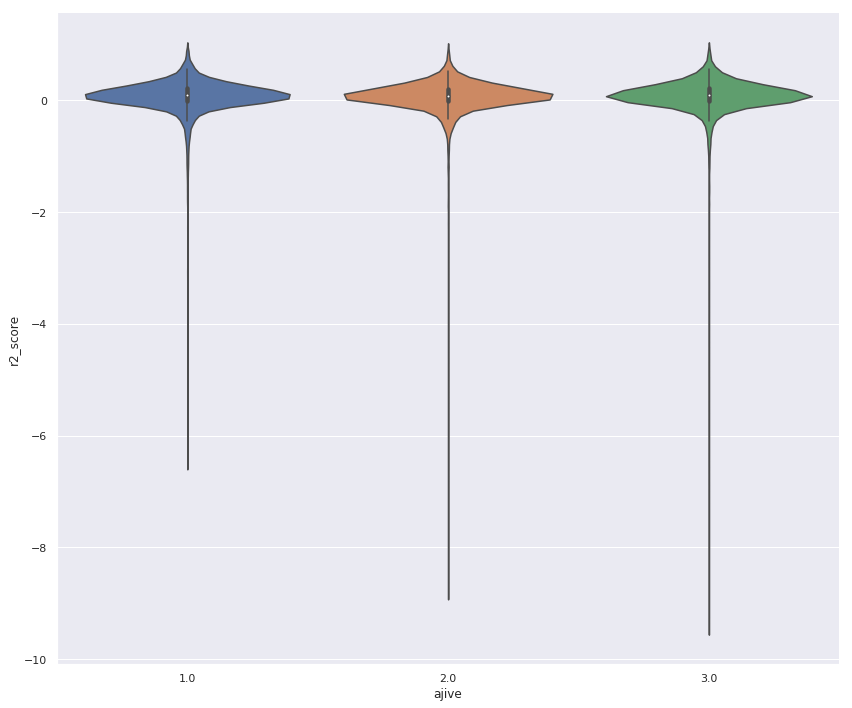

In [30]:
sns.set(font_scale=1)
sns.catplot(x='ajive', y='r2_score', data=data[data['r2_score']> -10], kind='violin', height=10, aspect=1.2)

# Norm

In [578]:
data = drug_data.join(ndata, on='run', rsuffix='drug')
data['norm'] = data['norm'].fillna('None')

In [591]:
data.groupby('norm').mean()[['r2_score', 'r_2_std']]

,r2_score,r_2_std
norm,,
MaxAbsScaler,0.045336,0.165921
MinMaxScaler,0.001895,0.347341
None,0.183966,0.276849
QuantileTransformer,0.049420,0.170666
StandardScaler,0.034564,0.122248


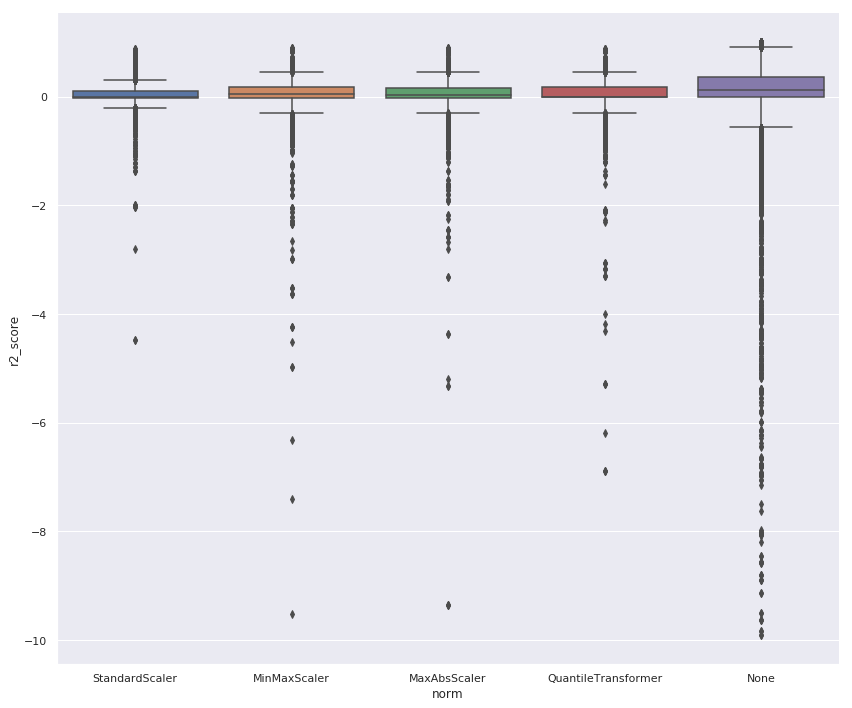

In [586]:
sns.set(font_scale=1)
sns.catplot(x='norm', y='r2_score', data=data[data['r2_score']> -10], kind='box', height=10, aspect=1.2)

# DA

In [110]:
data = drug_data.join(ndata, on='run', rsuffix='drug')
ajive = data[data['ajive'].notnull()]
feda = data[data['feda']==True]
neither = data[(data['feda']==False) & (data['ajive'].isnull())]

In [120]:
da = pd.concat([ajive, feda, neither], keys=['ajive', 'feda', 'neither']).reset_index()

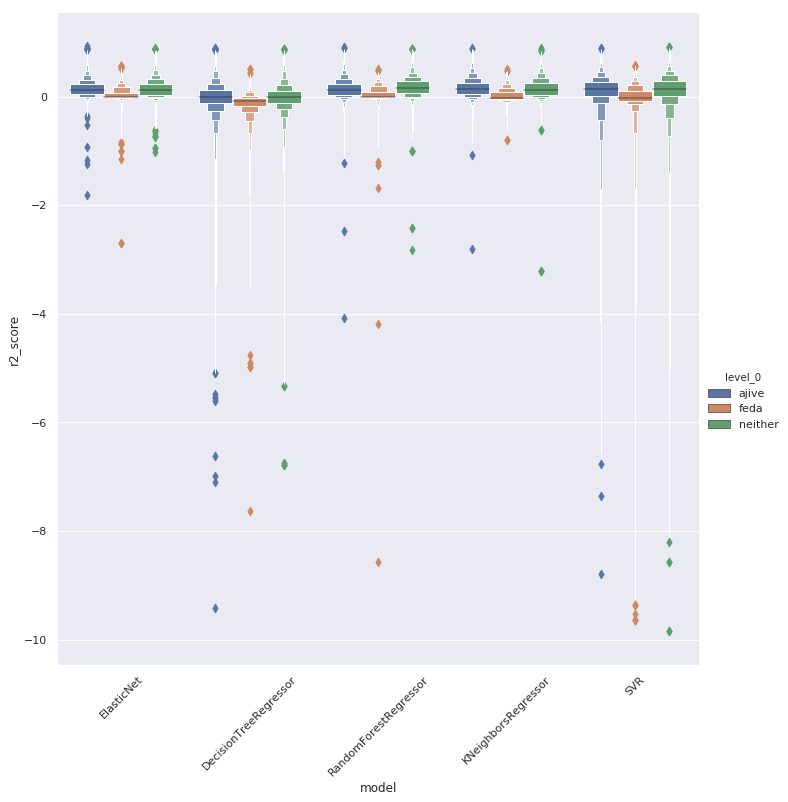

In [126]:
g = sns.catplot(x='model', y='r2_score', hue='level_0', data=da[da['r2_score']>-10], height=10, kind = 'boxen')
g.set_xticklabels(rotation=45)

# Best performing models

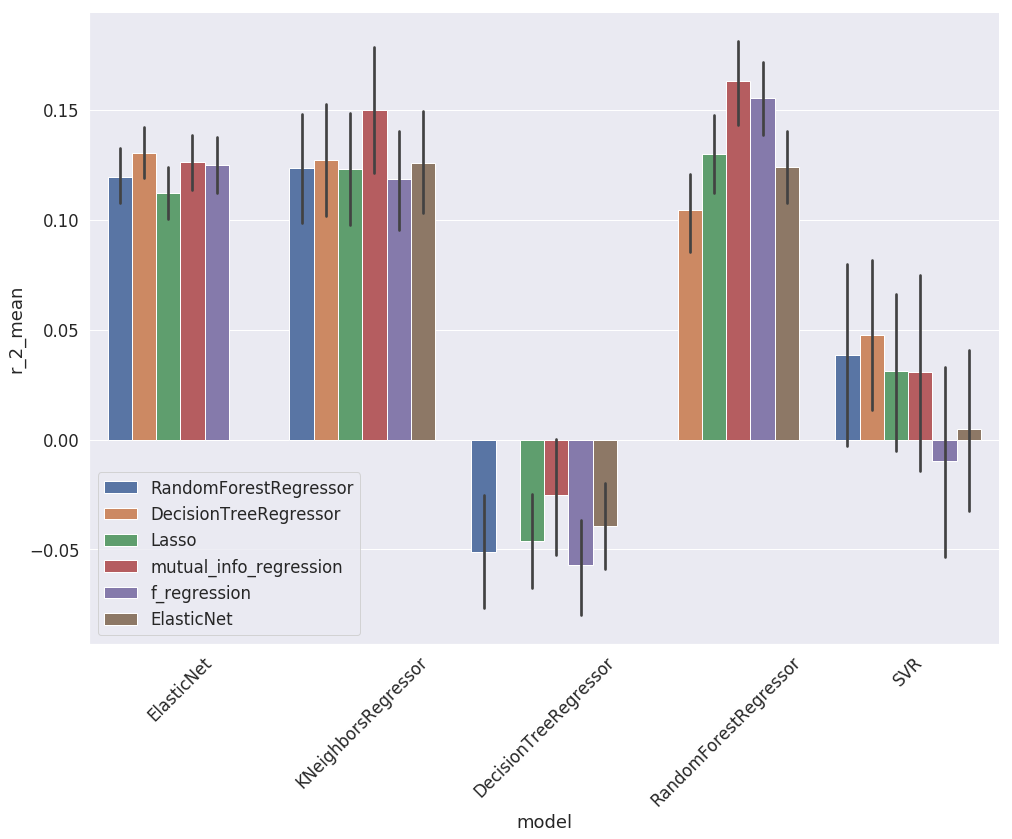

In [535]:
sns.set(font_scale=1.5)
g = sns.catplot(x = 'model', y='r_2_mean', hue='fs', data=ndata[ndata['r_2_mean'] > -0.6], kind='bar', height=12, aspect=1.2, legend=False)
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.legend(loc='lower left')
plt.savefig('fs and model.png')

# Influence of n on r2

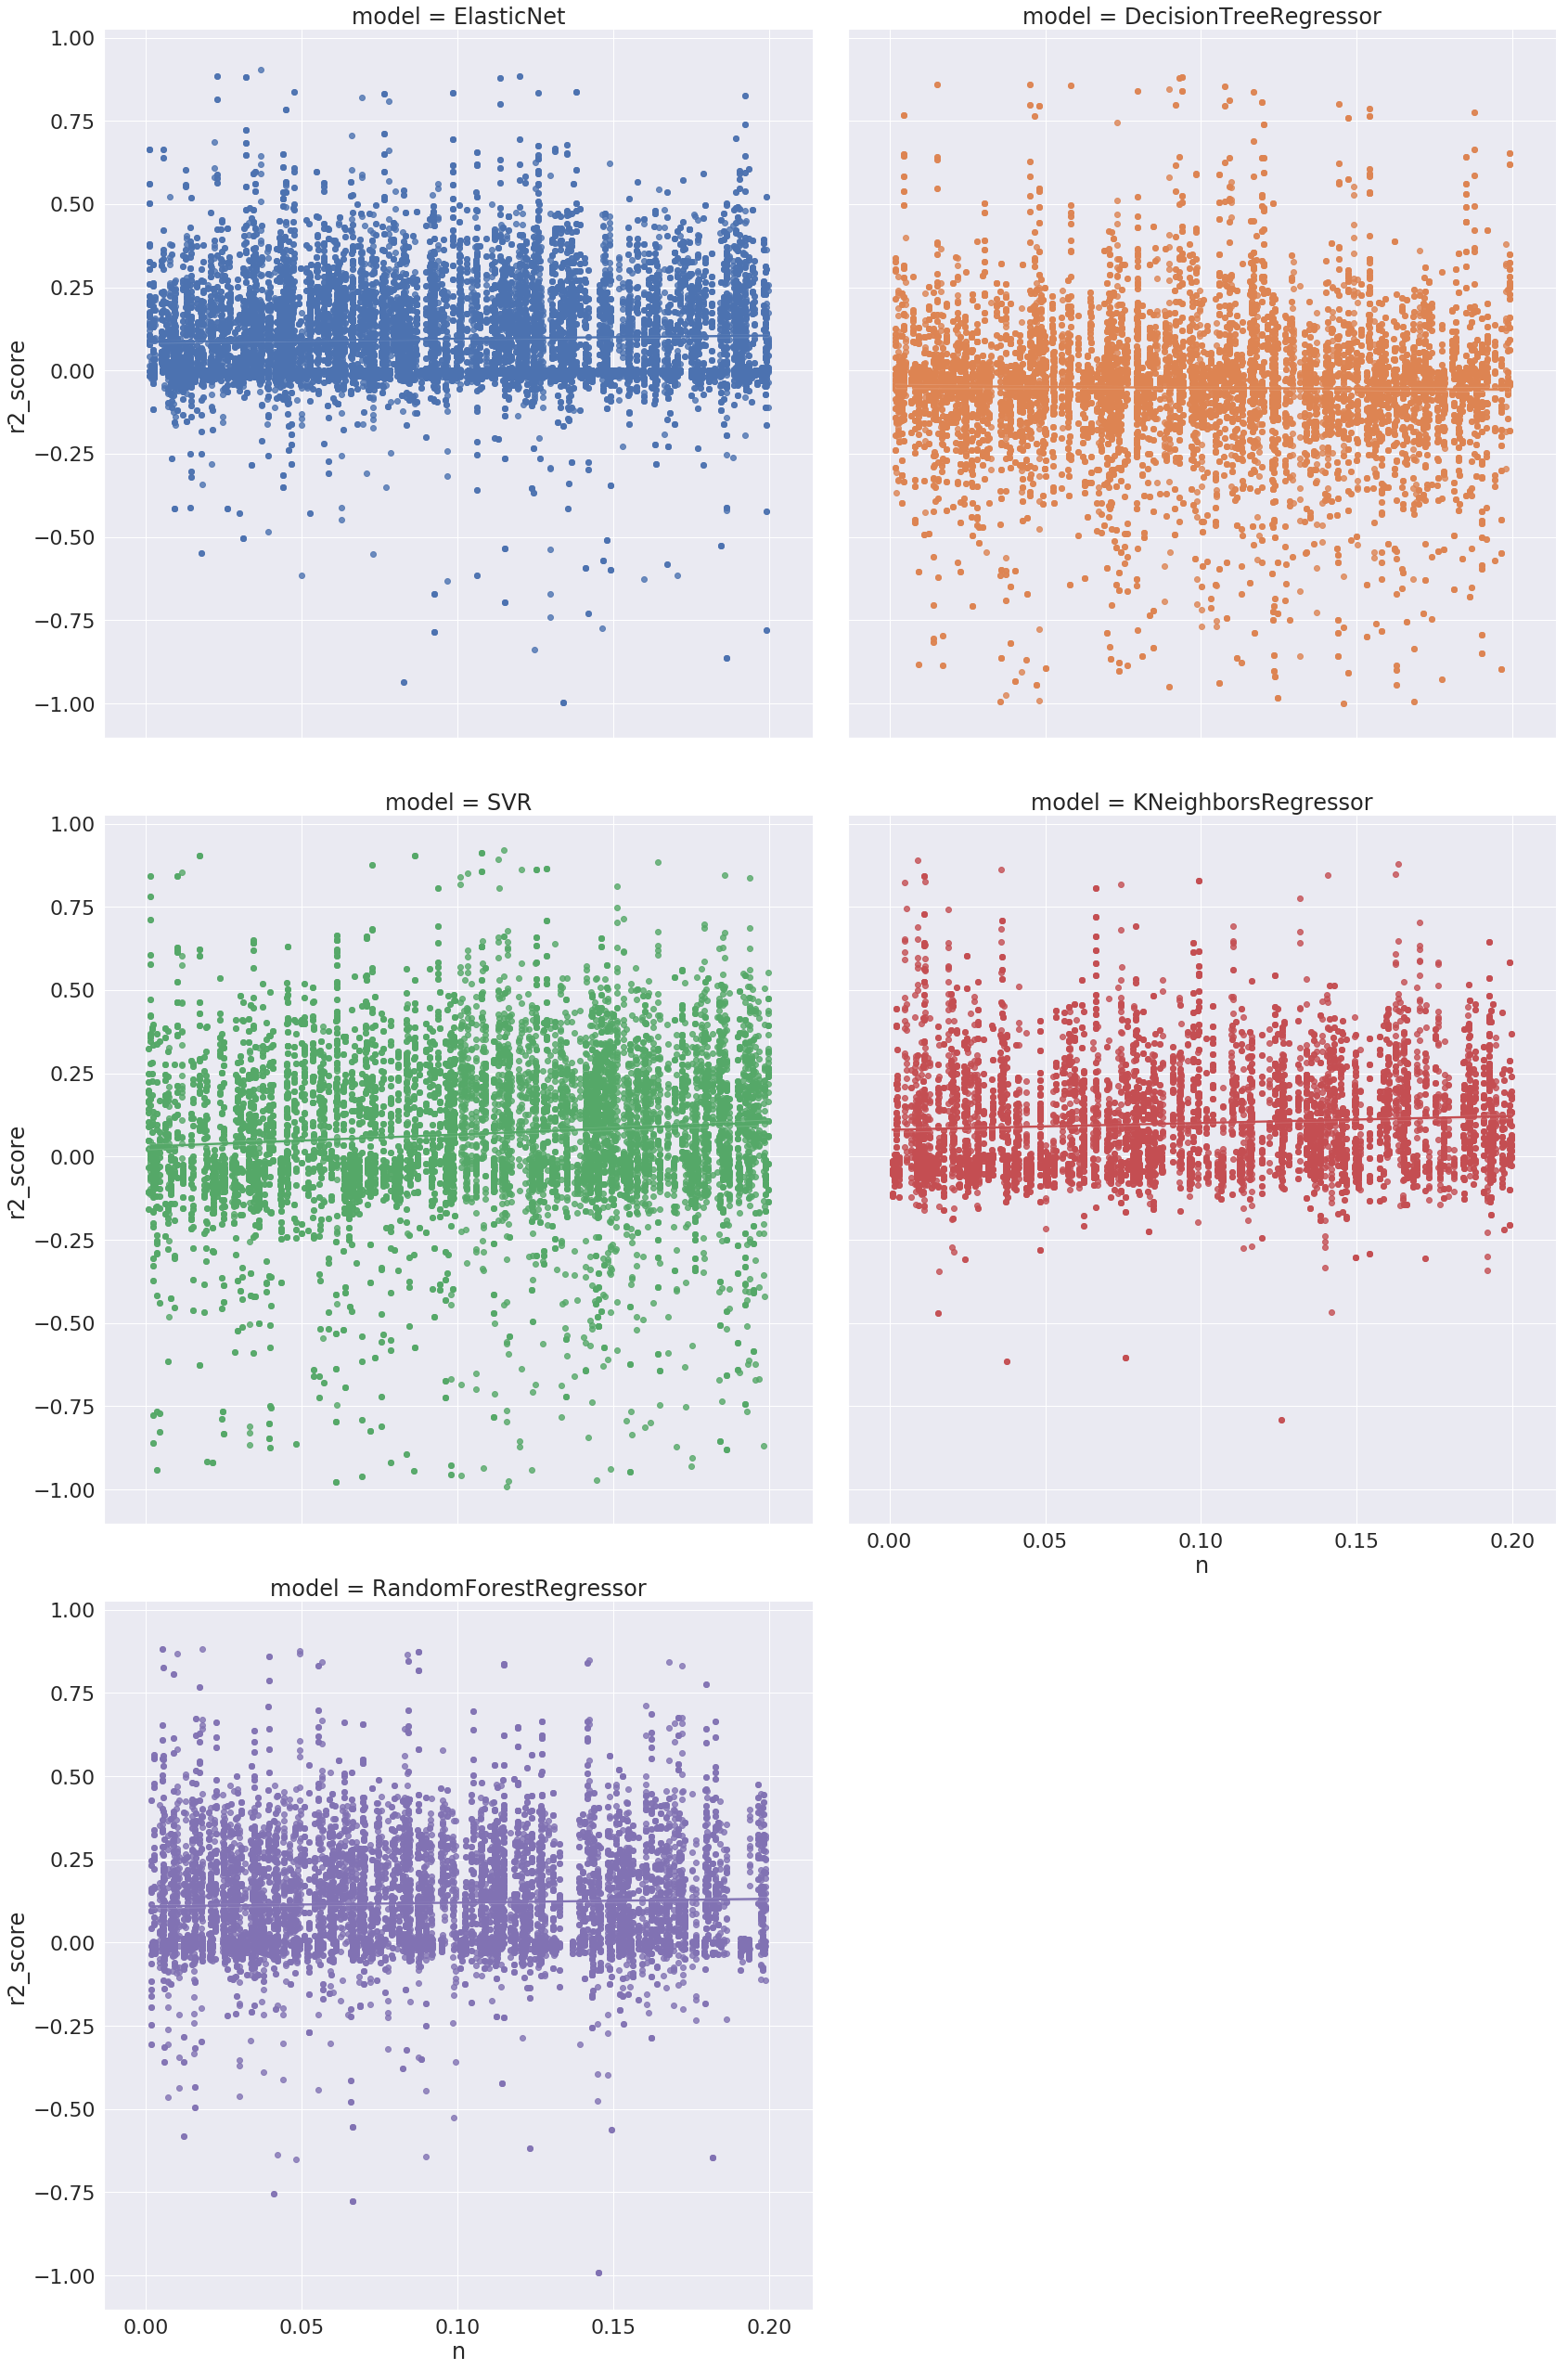

In [310]:
sns.set(font_scale=2)
g = sns.lmplot(x='n', y='r2_score', data=drug_data_j[drug_data_j['r2_score']>-1], col='model', hue='model', fit_reg=True, col_wrap=2, height=12, legend=False)
plt.savefig('model vs n.png')